In [1]:
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random
import tqdm

In [2]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [3]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations


def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [4]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_29154/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [5]:
end_game_types = list(games["first win condition"].unique())
print(end_game_types)

['left column', 'top left -> bottom right', 'top row', 'middle column', 'bottom left -> top right', 'right column', 'middle row', 'bottom row', nan]


In [6]:
non_9_move_games = games[games["steps till end state"] != 9]

In [7]:
non_9_move_games

,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127291,"[8, 7, 6, 5, 2, 4, 0, 3]",8,O,105999,54724,76016,72687,109328,131318,train,middle row,NaN,0.000055
127292,"[8, 7, 6, 5, 2, 4, 1, 3]",8,O,106001,54723,76014,72689,109326,116367,train,middle row,NaN,0.000005
127293,"[8, 7, 6, 5, 2, 4, 3, 1]",8,O,105998,54722,76017,72686,109329,186649,train,middle column,NaN,0.000136
127294,"[8, 7, 6, 5, 3, 1, 2, 4]",8,O,105985,54721,76030,72673,109342,189086,train,middle column,NaN,0.000153


In [8]:
# game_types x game x moves
game_kinds = [
    [
        [10] + eval(move)
        for move in non_9_move_games[
            non_9_move_games["first win condition"] == game_type
        ]["moves played"]
    ]
    for game_type in end_game_types[:-1]
]

In [53]:
label_mapping = {
    "left column": "lc",
    "top left -> bottom right": "tl > br",
    "top row": "tr",
    "middle column": "mc",
    "bottom left -> top right": "bl > tr",
    "right column": "rc",
    "middle row": "mr",
    "bottom row": "br",
}

In [48]:
# 30 seconds
game_count = 1_000
residual_stream_vectors = []
for games in game_kinds:
    games = random.sample(games, game_count)
    vectors = []
    for game in tqdm.tqdm(games):
        out = resid_pre_mlp(torch.tensor(game))[0, -1]
        vectors.append(out)
    residual_stream_vectors.append(torch.stack(vectors))
all_activations = torch.cat(residual_stream_vectors)
all_activations = all_activations.detach().cpu().T

100%|██████████| 1000/1000 [00:00<00:00, 2105.28it/s]


<Figure size 1000x1000 with 0 Axes>

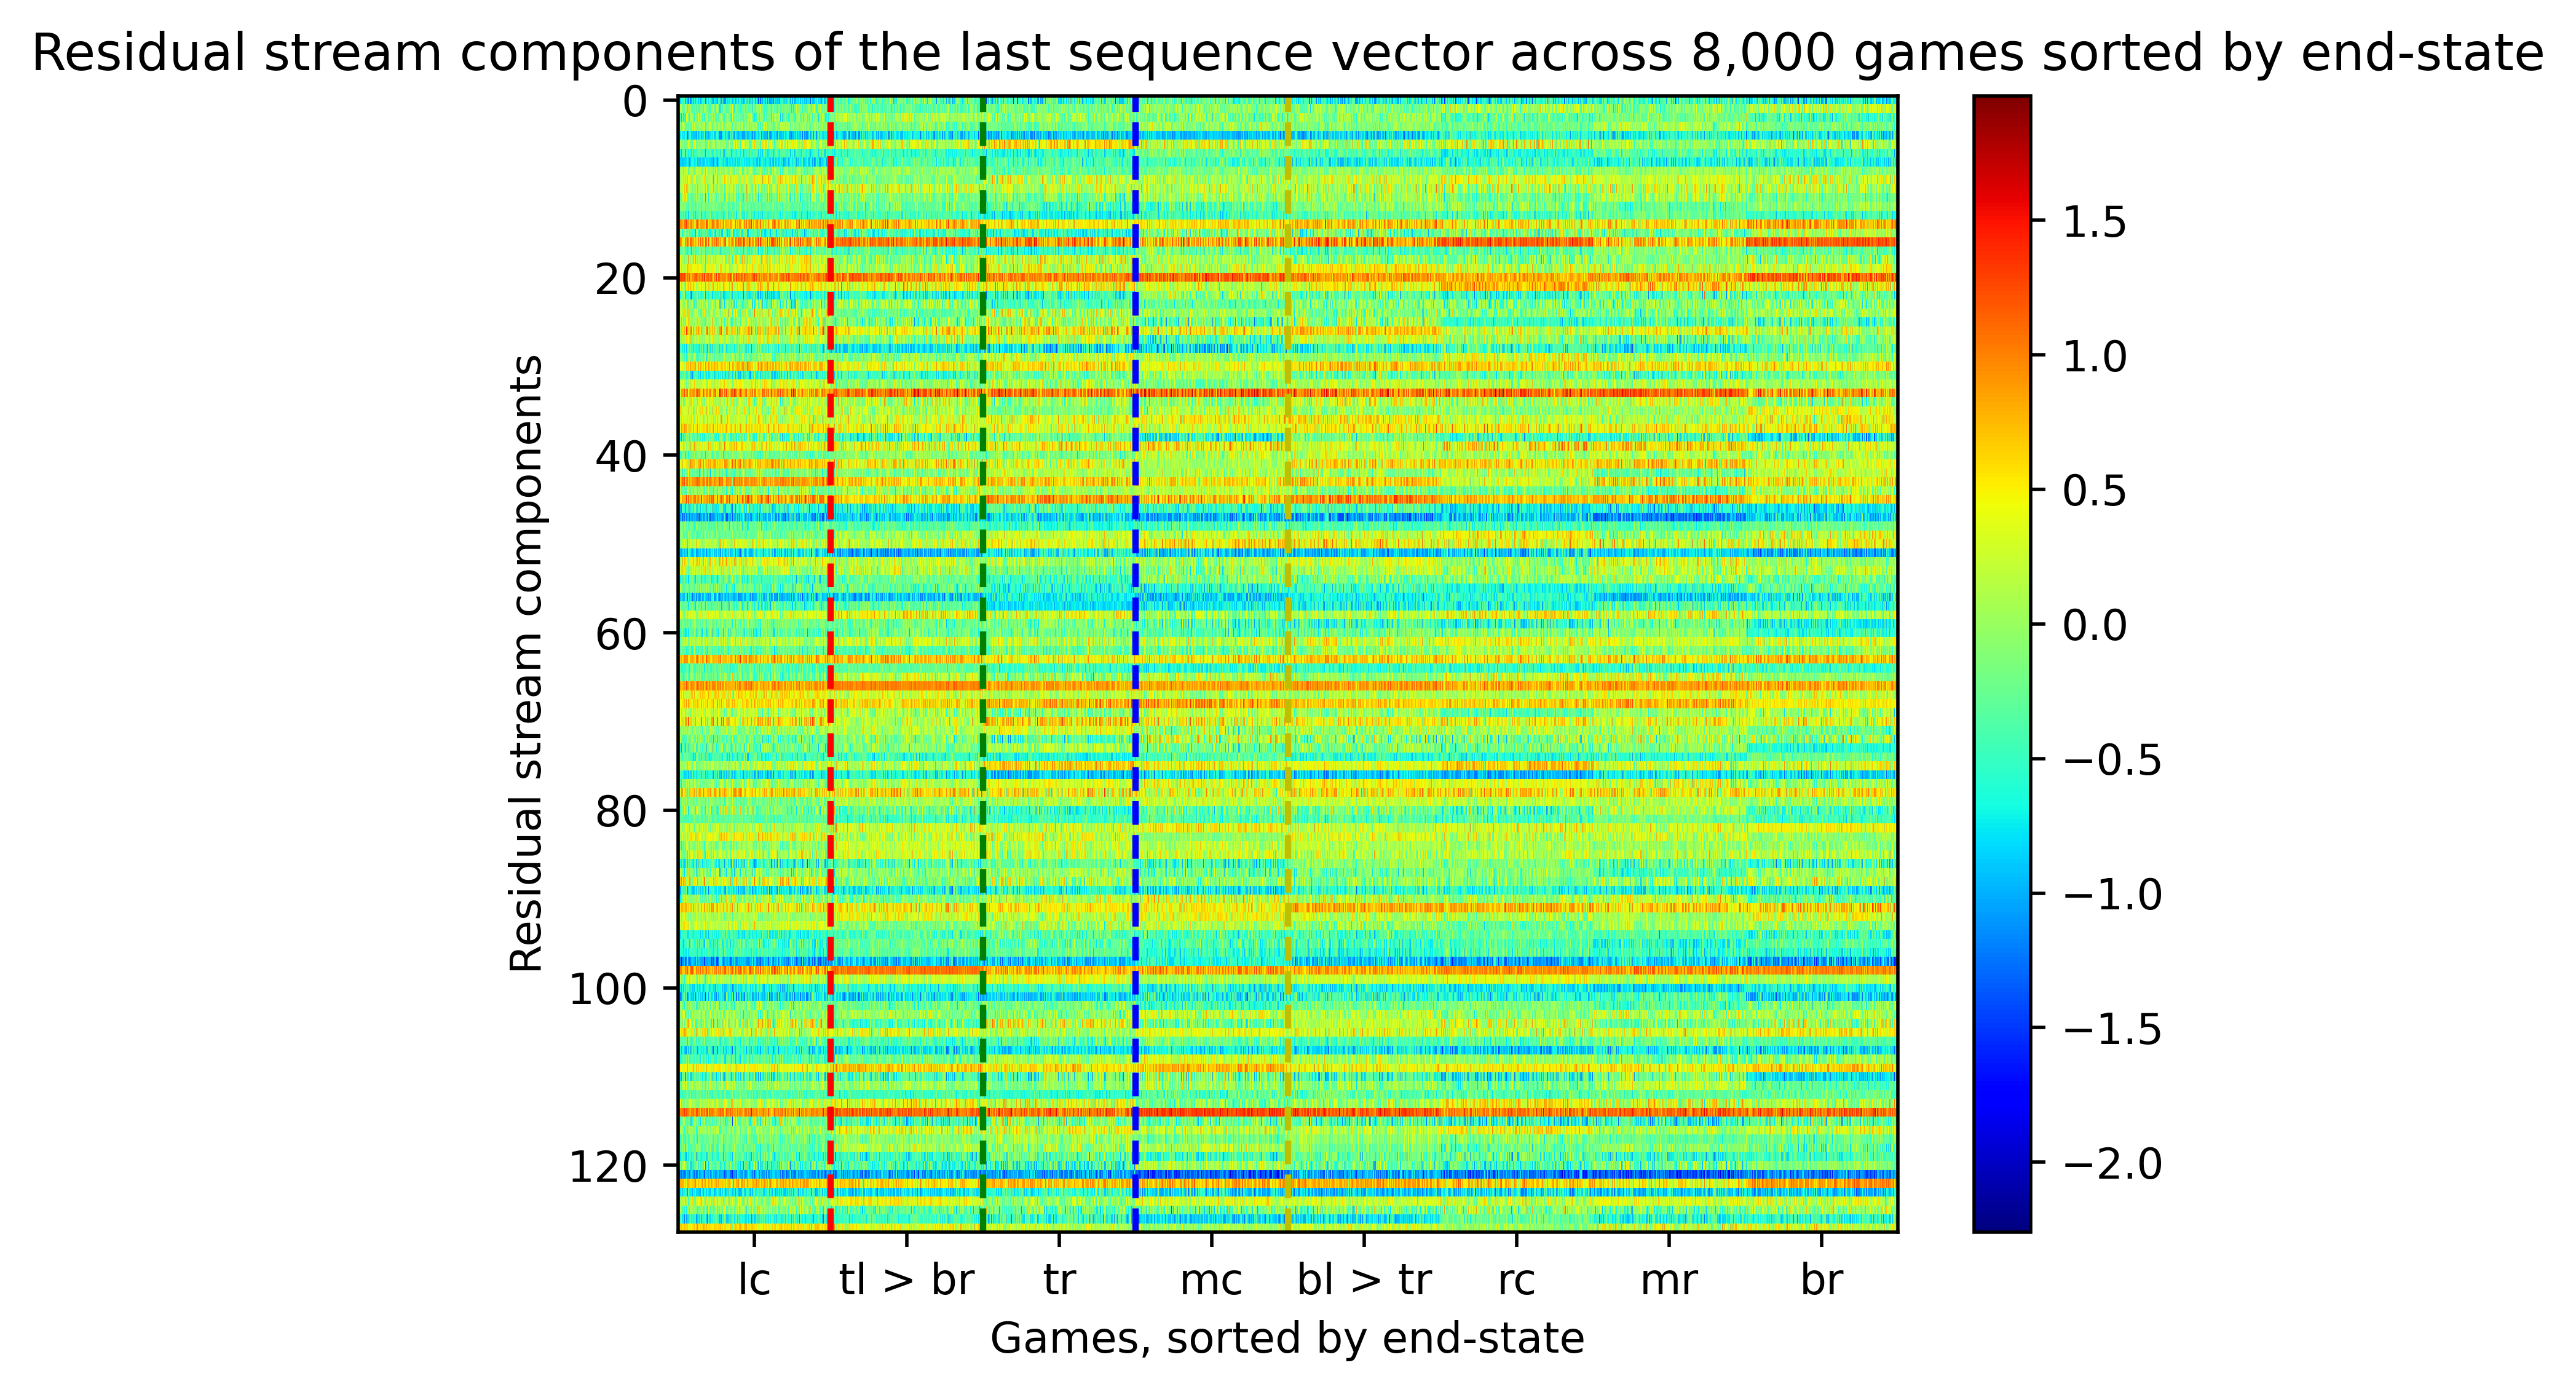

In [55]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_activations, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")
plt.xticks(
    list(range(500, 8000, 1000)), [label_mapping[l] for l in end_game_types[:-1]]
)
plt.ylabel("Residual stream components")
# title
plt.title(
    "Residual stream components of the last sequence vector across 8,000 games sorted by end-state",
    fontsize=12,
)
plt.gcf().set_facecolor("white")
plt.axvline(x=game_count, color="r", linestyle="--", label="moves till end state 5")
plt.axvline(x=game_count * 2, color="g", linestyle="--", label="moves till end state 6")
plt.axvline(x=game_count * 3, color="b", linestyle="--", label="moves till end state 7")
plt.axvline(x=game_count * 4, color="y", linestyle="--", label="moves till end state 8")

In [50]:
# 30 seconds
game_count = 1_000
residual_stream_vectors = []
for games in game_kinds:
    games = random.sample(games, game_count)
    vectors = []
    for game in tqdm.tqdm(games):
        out = resid_pre_mlp(torch.tensor(game))[0, -2]
        vectors.append(out)
    residual_stream_vectors.append(torch.stack(vectors))
all_activations = torch.cat(residual_stream_vectors)
all_activations = all_activations.detach().cpu().T

100%|██████████| 1000/1000 [00:00<00:00, 2201.50it/s]


<Figure size 1000x1000 with 0 Axes>

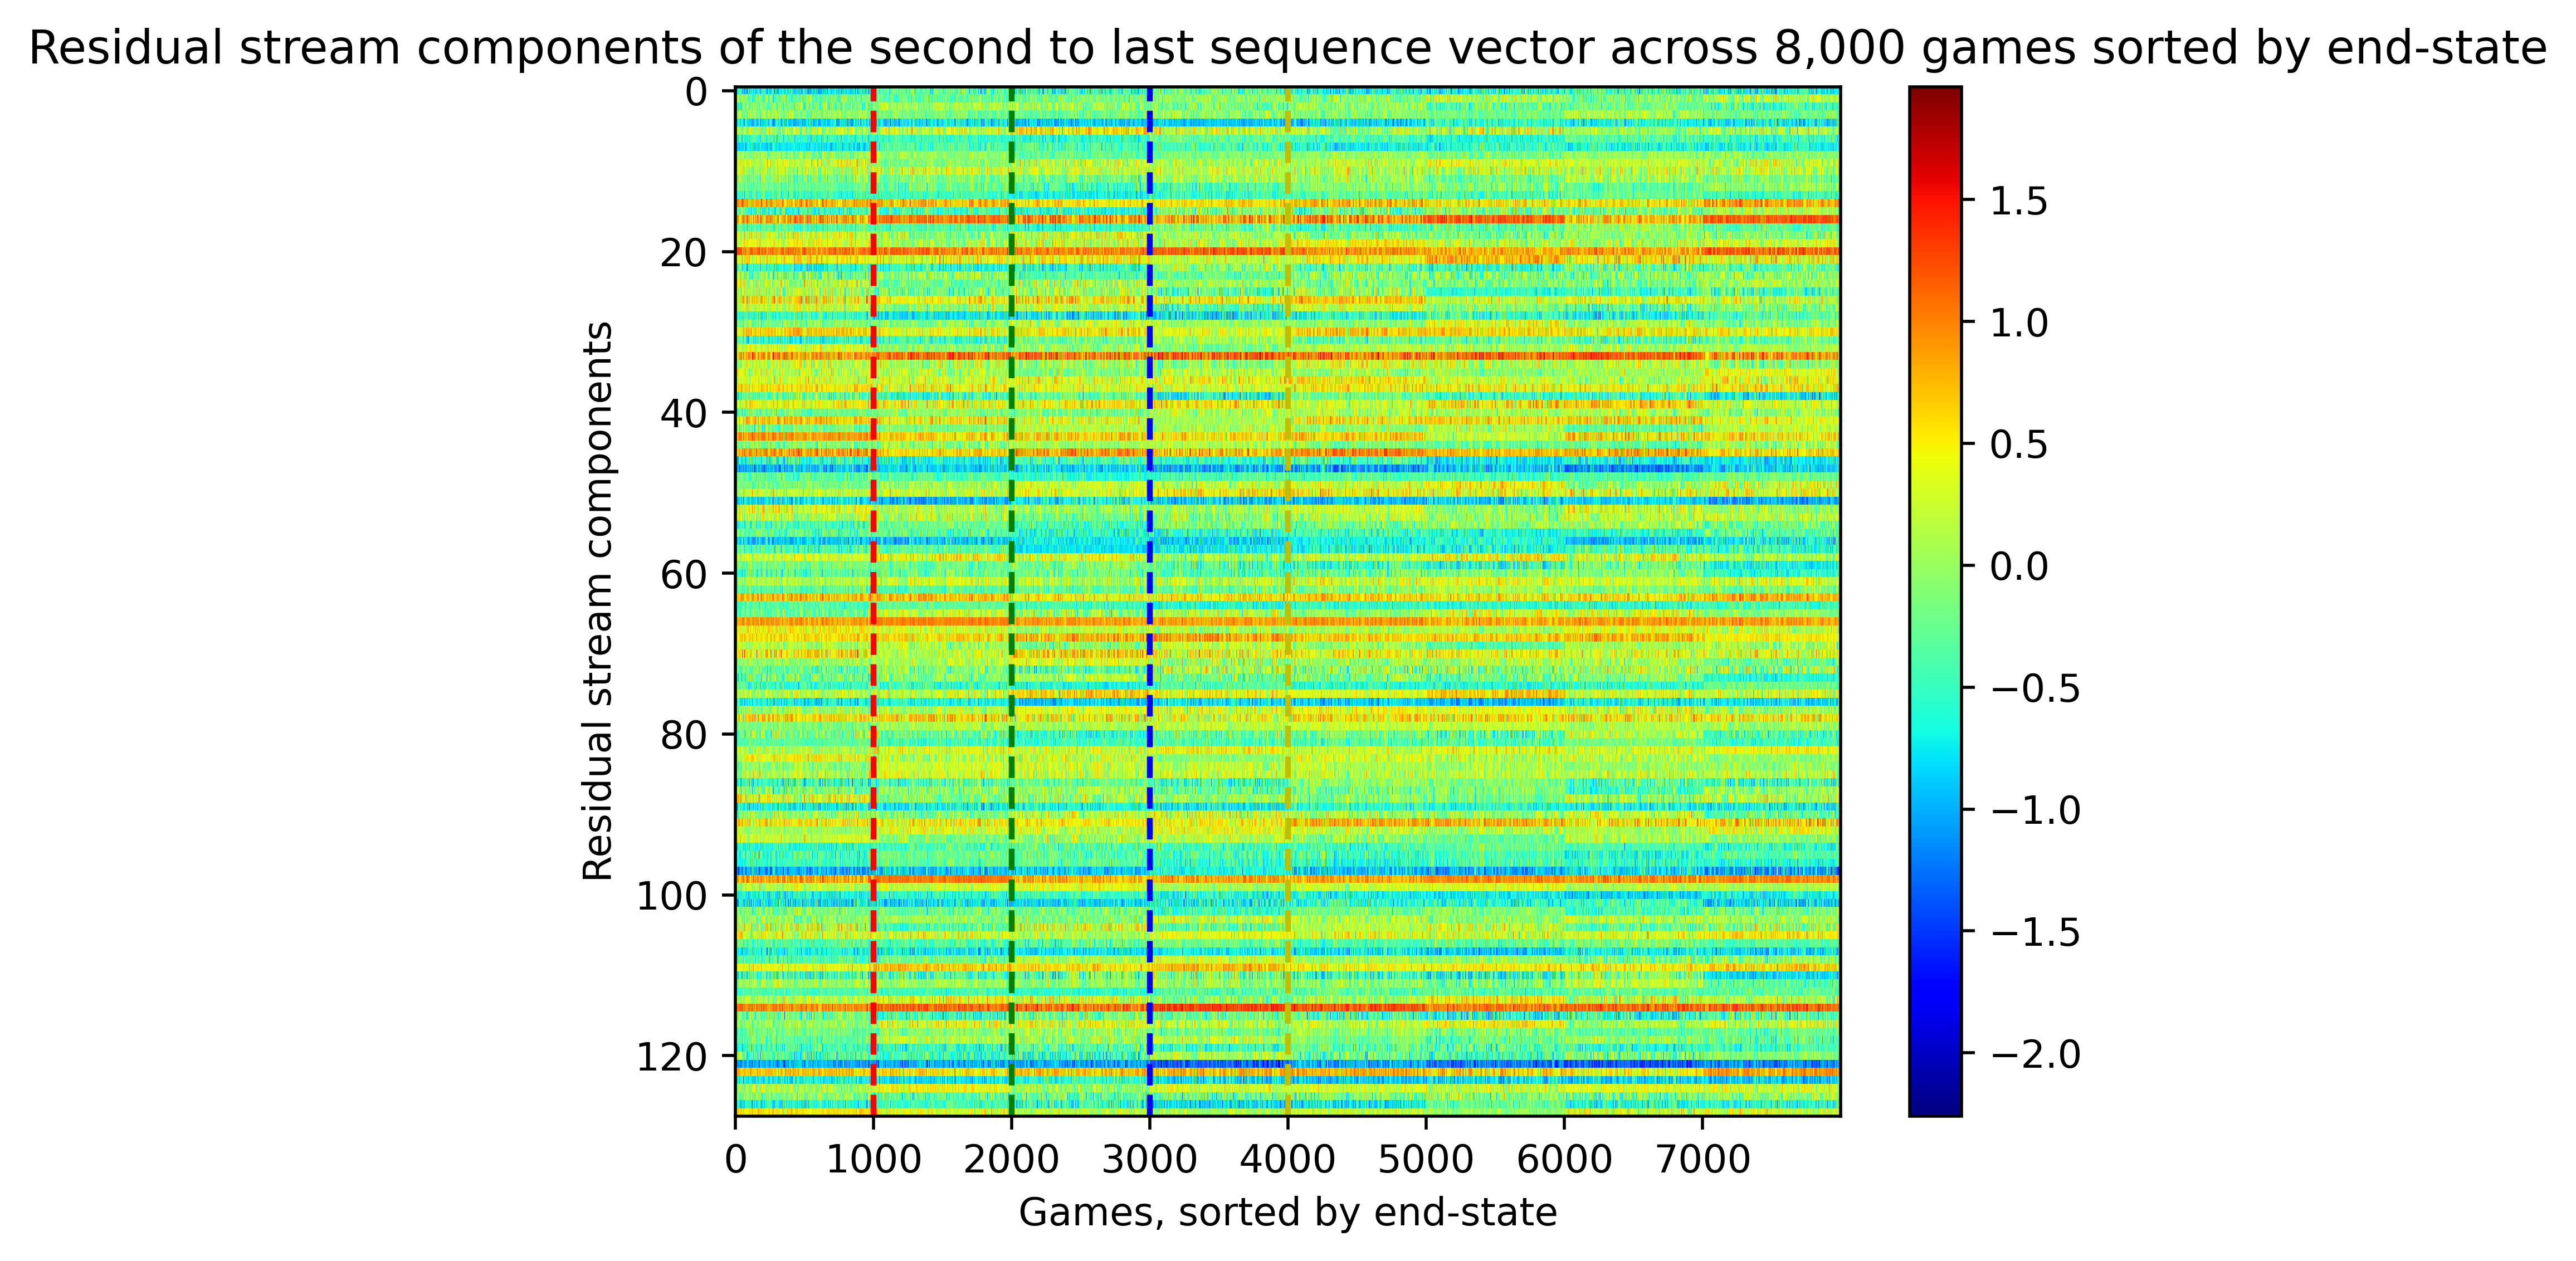

In [51]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_activations, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")
plt.ylabel("Residual stream components")
# title
plt.title(
    "Residual stream components of the second to last sequence vector across 8,000 games sorted by end-state",
    fontsize=12,
)
plt.gcf().set_facecolor("white")
plt.axvline(x=game_count, color="r", linestyle="--", label="moves till end state 5")
plt.axvline(x=game_count * 2, color="g", linestyle="--", label="moves till end state 6")
plt.axvline(x=game_count * 3, color="b", linestyle="--", label="moves till end state 7")
plt.axvline(x=game_count * 4, color="y", linestyle="--", label="moves till end state 8")

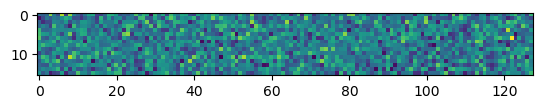

In [59]:
plt.imshow(model.blocks[0].attn.W_O[0].detach().to("cpu"))